In [19]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

tf.enable_eager_execution() ## enabling eager

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

In [20]:
print(tf.__version__)

1.11.0-rc1


In [21]:
## Check if it is executing eagerly
tf.executing_eagerly()

True

In [22]:
path_to_file = "./spa-eng/spa.txt"

In [23]:
def unicode_to_ascii(s):
    ## unicodedata.normalize -- is normalizing the sentence to NFD form
    return ''.join(c for c in unicodedata.normalize('NFD',s) 
                   if unicodedata.category(c) != 'Mn')

In [24]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [25]:
## fxn - create dataset - 
#i/p -> filename, how many pairs to be extracted
# o/p -> pairs of 2 languages

def create_dataset(filename, num_examples):
    
    lines = open(filename, encoding='UTF-8').read().strip().split('\n')
    ## lines[0] = 'English word    French word'
    
    word_pairs = [[preprocess_sentence(pair) for pair in line.split('\t')] for line in lines[:num_examples]]
    ## word_pairs[0] = [['english word',"French word"]]
    
    return word_pairs

In [26]:
## class creates dixtionary mapping -- word to index && index to word
class LanguageIndex():
    
    def __init__(self, lang):
        
        self.lang = lang
        self.word2idx = {} ## dict -- word 2 index
        self.idx2word = {} ## dict -- index to word
        self.vocab = set() ## creating a set for vocab
        ## caall this class's method
        self.create_index()
        
    def create_index(self):
        
        for phrase in self.lang: ## dividing the phrases of language
            self.vocab.update(phrase.split(" ")) ## adding to set
            
        self.vocab = sorted(self.vocab)
        
        self.word2idx['<pad>'] = 0 ## set first word's index as zero
        
        for index, word in enumerate(self.vocab): ## since enumerate therefore index
            self.word2idx[word] = index + 1
            
        for word, index in self.word2idx.items(): ## iterating over dictionary
            self.idx2word[index] = word

In [27]:
## finding max length
def max_length(tensor):
    return max(len(t) for t in tensor)

In [28]:

def load_dataset(path, num_examples):
    
    ## path -- filename, num_examples -- examples to be included
    pairs = create_dataset(path, num_examples) # word pairs created --pairs[0] = [['english word','french word']]
        
    ## calling init fxn of class and thus creating object
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    ## spanish sentences -- each word converted to it's index
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    
    ## english sentences -- each word converted to it's index
    target_tensor = [[targ_lang.word2idx[e] for e in en.split(' ')] for en,sp in pairs]
    
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    ## psot padding both tensors
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                maxlen=max_length_inp,
                                                               padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,
                                                                maxlen=max_length_tar,
                                                                padding='post')
    
    ## returning padded tensors' && i/p o/p lang objects, and aximum lengthh of oth tensors
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [30]:
num_examples = 30000
path_to_file = "../input/spa.txt"
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar= load_dataset(path_to_file, num_examples)

In [31]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size = 0.2)

In [32]:
print(len(input_tensor_train),len(input_tensor_val), len(target_tensor_train), len(target_tensor_val))

24000 6000 24000 6000


In [33]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE/ BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

## creating dataset using data API
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
## Settign batch -- .batch will add extra dimension batch size denoting no of element witjin a batch
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True) ## i.e drop the last batch

In [34]:
## defining GRU UNits
def gru(units):
    
    return tf.keras.layers.GRU(units, return_sequences = True, 
                    return_state = True, recurrent_activation='sigmoid',
                        recurrent_initializer='glorot_uniform')

In [35]:
## Encoder class
class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        ## calling parent's contructor
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        ## state is hidden of current 
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [36]:
## Decoder class
class Decoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        
        super(Decoder,self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size) ## final 
        
        ## For attention
        self.W1 = tf.keras.layers.Dense(self.dec_units) ##op shape: (batch_size,...,dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)## op shape: (batch size, ... dec units)
        self.V = tf.keras.layers.Dense(1) ## op shape: (Batch size,...,1)
        
        ## x is input
        ## enc_utput.shape = (batch size, max lenghth, hidden size)
        ## hidden.shape = (batch size, hidden size)
    def call(self,x,hidden, enc_output):
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1) ## add dimension at axis = 1
        ## shape is (batch size, 1, hidden size)
        
       # print("Hidden_with_time_axis: {}".format(tf.shape(hidden_with_time_axis)))
        
        score = tf.nn.tanh( self.W1(enc_output) + self.W2(hidden_with_time_axis))
## score.shape after tanh shape woud be same i.e (batch_size, max_length, dec_units)

#         print("Score: {}".format(tf.shape(score)))
        
## after self.V -- shape is (batch_size, max_length, 1) -- after softmax shape is same
        attention_weights = tf.nn.softmax(self.V(score), axis = 1)
    
#         print("Attention_weights: {}".format(tf.shape(attention_weights)))
        
        context_vector = attention_weights * enc_output
        
#         print("Context_vector: {}".format(tf.shape(context_vector)))
        
        context_vector = tf.reduce_sum(context_vector, axis = 1)
#         print("Context_vecotr: {}".format(tf.shape(context_vector)))
        
        x = self.embedding(x)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        
        output, state = self.gru(x)
        
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [37]:
## Objects defining
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [38]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = real, logits = pred) * mask
    return tf.reduce_mean(loss)

In [39]:
checkpoint_dir = "./checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer = optimizer, 
                                 encoder = encoder, decoder = decoder)

In [40]:
EPOCHS = 10

for epoch in range(EPOCHS):
    
    start = time.time()
    
    hidden = encoder.initialize_hidden_state() ## calling object fxns
    total_loss = 0
    
    ## since enumerate batch will have 0,1,2,...
    ##inp - eng word;  targ - freanch worsd
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        ## start backprop
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
#             print("Batch {}".format(batch))
#             print("input shape : {}".format(tf.shape(inp)))
#             print("hiddne shape: {}".format(tf.shape(hidden)))
#             print("Encoder output shape: {}".format(tf.shape(enc_output)))
#             print("Encoder hiddern shape: {}".format(tf.shape(enc_hidden)))
            
            dec_hidden = enc_hidden
      ## We are doing batch training -- therefore * batch size      
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
            ## dec_input.shape = (64,1)
            ## dec_input - [5] repeated 64times
  ## teacher feeding --- for every decoder cell will feeding dec_input          
            for t in range(1, targ.shape[1]): ## targ.shape[1] == 11
                
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
#                 print("For t: {}".format(t))
#                 print(tf.shape(predictions))
#                 print(tf.shape(dec_hidden))
                
                loss += loss_function(targ[:,t], predictions)
                
                dec_input = tf.expand_dims(targ[:,t], 1)
                ## dec_input.shape = (64,1)
                ## dec_input are basically 64 ints -- one for each sample in batch
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        variables = encoder.variables + decoder.variables
        ## compute gradients
        gradients = tape.gradient(loss, variables) ## i.e diff of loss wrt variables
        
        optimizer.apply_gradients(zip(gradients, variables))
        ## update variables with gradients
        
        if batch % 100 == 0:
            print("Epoch {} Batch {} Loss {:.4f}".format(epoch +1, batch, 
                                                         batch_loss.numpy()))
            
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6744
Epoch 1 Batch 100 Loss 2.2491
Epoch 1 Batch 200 Loss 1.8030
Epoch 1 Batch 300 Loss 1.7373
Epoch 1 Loss 2.0695
Time taken for 1 epoch 157.9690134525299 sec

Epoch 2 Batch 0 Loss 1.5630
Epoch 2 Batch 100 Loss 1.5414
Epoch 2 Batch 200 Loss 1.5848
Epoch 2 Batch 300 Loss 1.4493
Epoch 2 Loss 1.5219
Time taken for 1 epoch 157.32786417007446 sec

Epoch 3 Batch 0 Loss 1.2022
Epoch 3 Batch 100 Loss 1.3390
Epoch 3 Batch 200 Loss 1.2607
Epoch 3 Batch 300 Loss 1.1562
Epoch 3 Loss 1.2032
Time taken for 1 epoch 157.24312281608582 sec

Epoch 4 Batch 0 Loss 1.0034
Epoch 4 Batch 100 Loss 0.9320
Epoch 4 Batch 200 Loss 0.8566
Epoch 4 Batch 300 Loss 0.9028
Epoch 4 Loss 0.8871
Time taken for 1 epoch 157.5782060623169 sec

Epoch 5 Batch 0 Loss 0.6579
Epoch 5 Batch 100 Loss 0.7265
Epoch 5 Batch 200 Loss 0.6452
Epoch 5 Batch 300 Loss 0.6247
Epoch 5 Loss 0.6316
Time taken for 1 epoch 158.78693294525146 sec

Epoch 6 Batch 0 Loss 0.4052
Epoch 6 Batch 100 Loss 0.3777
Epoch 6 Batch 200 L

In [41]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    
                                #(11,16) -- 11 rows 16 columns of zeros
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence) 
    ## Now <start> and <end> has been attached
    
    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], 
                                                           maxlen = max_length_inp, padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    ## initilising hidden layer -- 1024 zeros
    hidden = [tf.zeros((1,units))]
    
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)
    
    for i in range(max_length_targ): ## 11
        predictions, dec_hidden, attention_weights = decoder(dec_input, 
                                                             dec_hidden, enc_out)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.multinomial(predictions, num_samples = 1)[0][0].numpy()
        
        result += targ_lang.idx2word[predicted_id] + ' '
        
        ## if end is reached of sentencec
        if targ_lang.idx2word[predicted_id] == "<end>":
            return result, sentence, attention_plot
        
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, sentence, attention_plot

In [53]:
def plot_attention(attention, sentence, predicted_sentence):
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap = 'viridis')
    
    fontdict = {'fontsize' : 14}
    
    ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation = 90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)
    
    plt.show()

In [60]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    
    print("Input : {}".format(sentence))
    print("Predicted translation: {}".format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [61]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input : <start> hace mucho frio aqui . <end>
Predicted translation: it s too cold here . <end> 


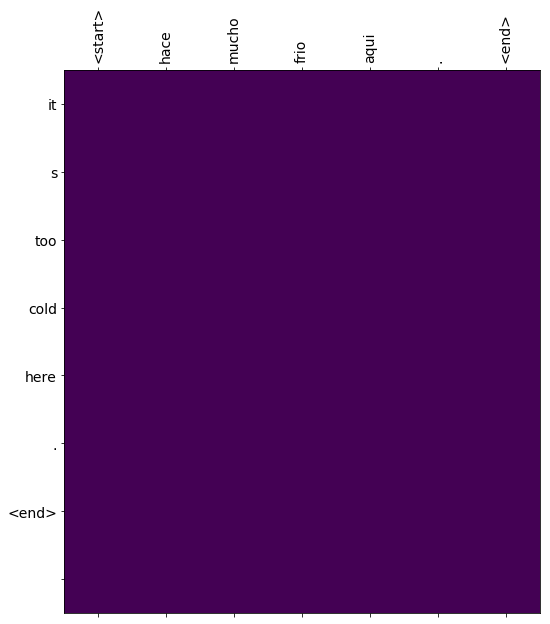

In [62]:
translate('hace mucho frio aqui.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_tar)

Input : <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


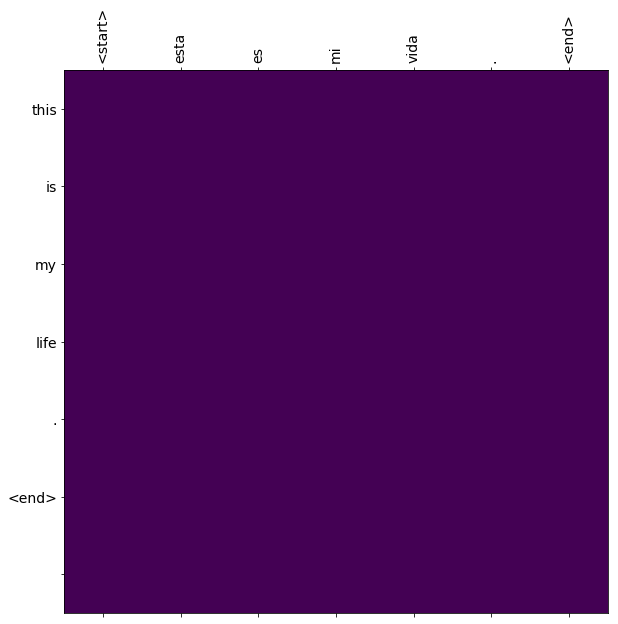

In [46]:
translate('esta es mi vida.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_tar)


Input : <start> ¿ todavia estan en casa ? <end>
Predicted translation: are they still at home ? <end> 


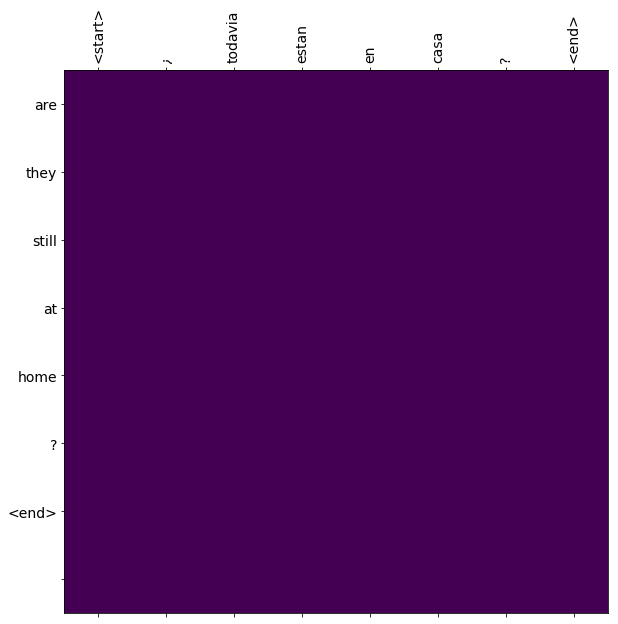

In [47]:
translate('¿todavia estan en casa?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_tar)

Input : <start> trata de averiguarlo . <end>
Predicted translation: wash up at find . <end> 


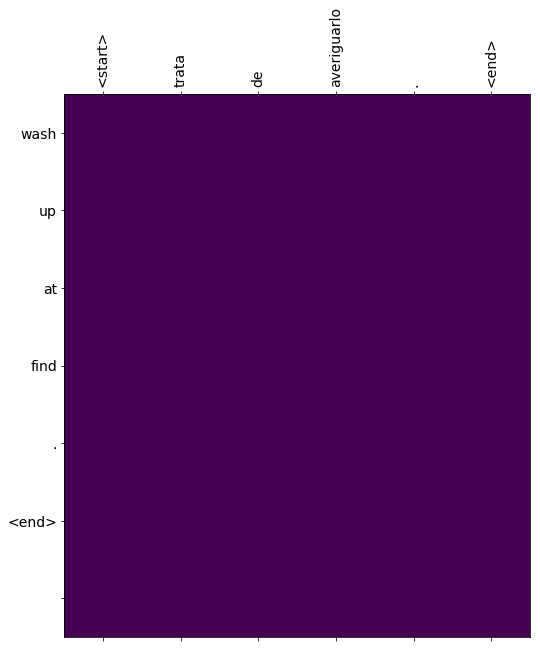

In [48]:
translate('trata de averiguarlo.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_tar)